##### Step1:Data Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [2]:
spam_data = pd.read_csv("C:/Users/Admin/Downloads/Excel Files/enron_spam_data.csv", encoding='ISO-8859-1')



In [3]:
spam_data

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14
...,...,...,...,...,...
33711,33711,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,"hello , welcome to gigapharm onlinne shop .\np...",spam,2005-07-29
33712,33712,all prescript medicines are on special . to be...,i got it earlier than expected and it was wrap...,spam,2005-07-29
33713,33713,the next generation online pharmacy .,are you ready to rock on ? let the man in you ...,spam,2005-07-30
33714,33714,bloow in 5 - 10 times the time,learn how to last 5 - 10 times longer in\nbed ...,spam,2005-07-30


In [4]:
spam_data.shape

(33716, 5)

In [5]:
spam_data.columns

Index(['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date'], dtype='object')

In [6]:
spam_data.describe()

,Message ID
count,33716.000000
mean,16857.500000
std,9733.115174
min,0.000000
25%,8428.750000
50%,16857.500000
75%,25286.250000
max,33715.000000


In [7]:
spam_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Message ID  33716 non-null  int64 
 1   Subject     33427 non-null  object
 2   Message     33345 non-null  object
 3   Spam/Ham    33716 non-null  object
 4   Date        33716 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [8]:
spam_data.isnull().sum()

Message ID      0
Subject       289
Message       371
Spam/Ham        0
Date            0
dtype: int64

In [9]:
spam_data.duplicated().sum()

0

# Step 2:Data Cleaning

In [10]:
# Preprocess: Handle missing values

spam_data['Subject'].fillna('', inplace=True)

spam_data.dropna(subset=['Message'],inplace=True)
spam_data.isnull().sum()

Message ID    0
Subject       0
Message       0
Spam/Ham      0
Date          0
dtype: int64

# Step 3: EDA(Exploratory Data Analysis)

In [11]:
# Calculate the length of each subject
spam_data['Subject_length'] = spam_data['Subject'].apply(len)
# Calculate the length of each Message
spam_data['Message_length'] = spam_data['Message'].apply(len)


 # 1. Distribution of spam versus ham emails

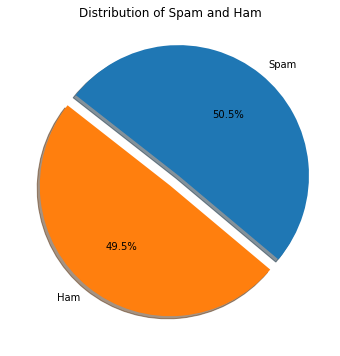

In [12]:
spam_counts=spam_data['Spam/Ham'].value_counts()
plt.figure(figsize=(10,6))
plt.pie(spam_counts,labels=['Spam','Ham'],autopct='%1.1f%%',startangle=1400,shadow=True,explode=(0.1,0))
plt.title('Distribution of Spam and Ham')
plt.show()

#  2. Length distribution of Subject and Message

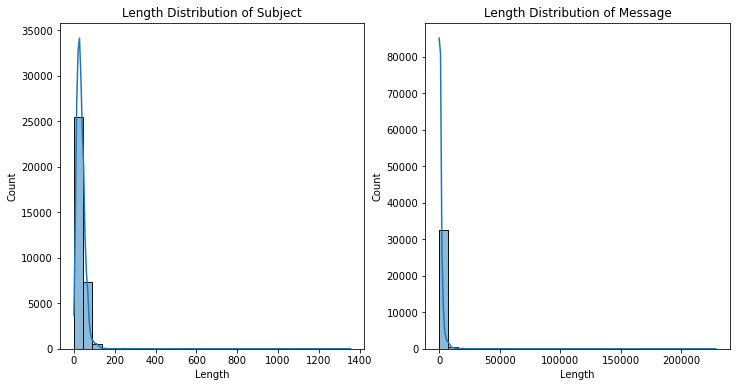

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(spam_data['Subject_length'], bins=30, kde=True)
plt.title('Length Distribution of Subject')
plt.xlabel('Length')

plt.subplot(1, 2, 2)
sns.histplot(spam_data['Message_length'], bins=30, kde=True)
plt.title('Length Distribution of Message')
plt.xlabel('Length')
plt.show()

In [20]:
pip install wordcloud matplotlib


Note: you may need to restart the kernel to use updated packages.


# # 3. Time Series Plots
# Ensure the 'Date' column is in datetime format

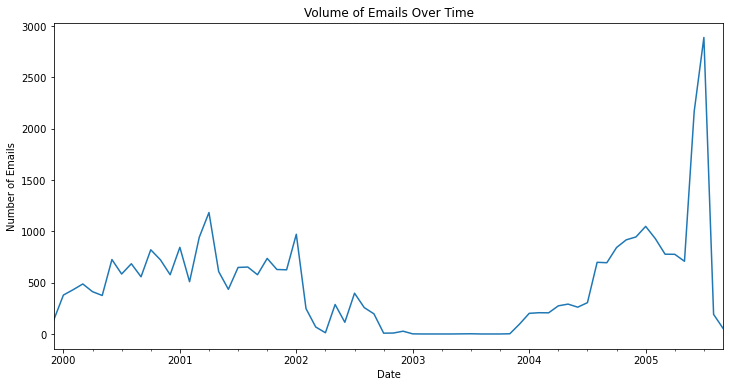

In [24]:
spam_data['Date'] = pd.to_datetime(spam_data['Date'], errors='coerce')
spam_data.set_index('Date', inplace=True)

# a. Volume of emails over time
plt.figure(figsize=(12, 6))
spam_data['Message ID'].resample('M').count().plot()
plt.title('Volume of Emails Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Emails')
plt.show()

#  b. Volume of spam versus ham emails over time

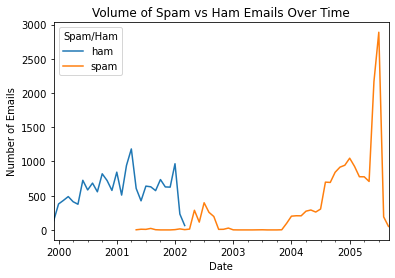

In [25]:
spam_data.groupby('Spam/Ham')['Message ID'].resample('M').count().unstack(0).plot()
plt.title('Volume of Spam vs Ham Emails Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Emails')
plt.show()

# 4. Box Plots
# a. Length of Subject and Message by spam versus ham

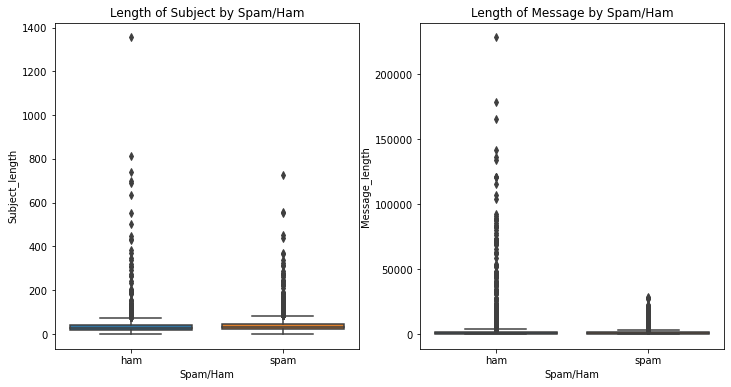

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Spam/Ham', y='Subject_length', data=spam_data)
plt.title('Length of Subject by Spam/Ham')
plt.subplot(1, 2, 2)
sns.boxplot(x='Spam/Ham', y='Message_length', data=spam_data)
plt.title('Length of Message by Spam/Ham')
plt.show()

# 5. Plot the stacked histogram of subject lengths

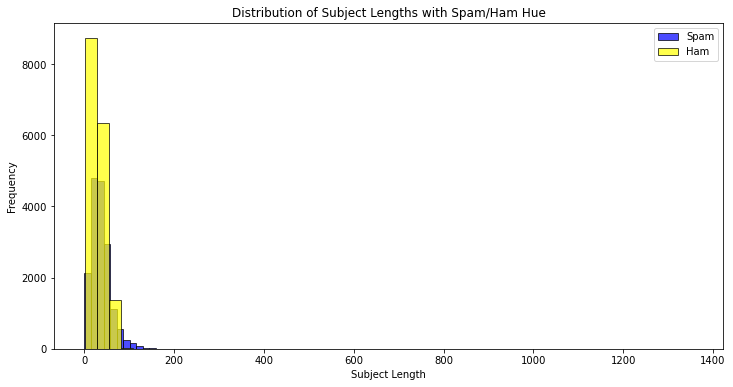

In [30]:

# Separate spam and ham emails
spam_email =spam_data[spam_data['Spam/Ham'] == 'spam']
ham_email = spam_data[spam_data['Spam/Ham'] == 'ham']

# Plot the stacked histogram of subject lengths
plt.figure(figsize=(12, 6))
plt.hist(spam_email['Subject_length'], bins=50, color='Blue', alpha=0.7, label='Spam', edgecolor='black', stacked=True)
plt.hist(ham_email['Subject_length'], bins=50, color='yellow', alpha=0.7, label='Ham', edgecolor='black', stacked=True)
#plt.hist([spam_email['text_length'], ham_email['text_length']], bins=50, color=['red', 'green'], alpha=0.7, label=['Spam', 'Ham'], edgecolor='black', stacked=True)

plt.title('Distribution of Subject Lengths with Spam/Ham Hue')
plt.xlabel('Subject Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# # Plot the stacked histogram of subject lengths

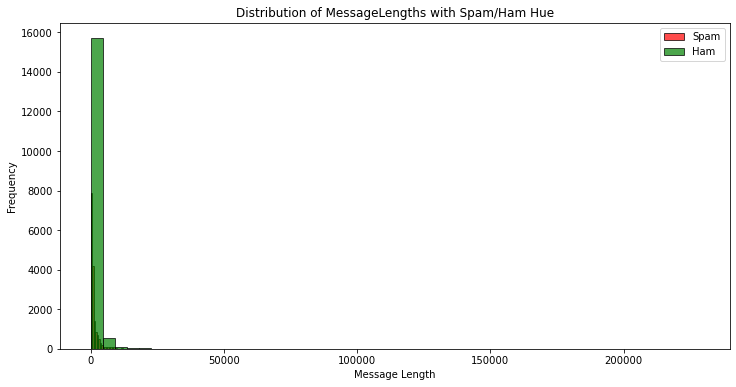

In [31]:
# Separate spam and ham emails
spam_email = spam_data[spam_data['Spam/Ham'] == 'spam']
ham_email = spam_data[spam_data['Spam/Ham'] == 'ham']

# Plot the stacked histogram of subject lengths
plt.figure(figsize=(12, 6))
plt.hist(spam_email['Message_length'], bins=50, color='red', alpha=0.7, label='Spam', edgecolor='black', stacked=True)
plt.hist(ham_email['Message_length'], bins=50, color='green', alpha=0.7, label='Ham', edgecolor='black', stacked=True)
#plt.hist([spam_email['text_length'], ham_email['text_length']], bins=50, color=['red', 'green'], alpha=0.7, label=['Spam', 'Ham'], edgecolor='black', stacked=True)

plt.title('Distribution of Message Lengths with Spam/Ham Hue')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# 6.Correlation Matrix

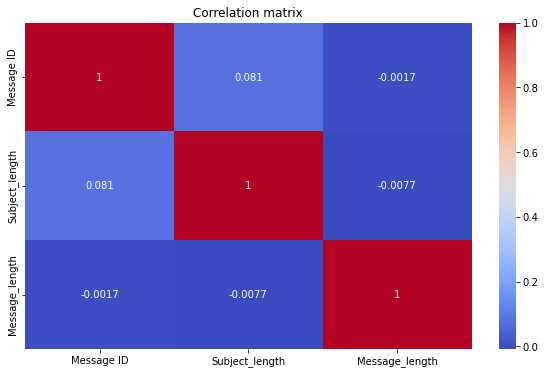

In [32]:
plt.figure(figsize=(10,6))
corr_mx=spam_data.corr()
sns.heatmap(corr_mx,annot=True,cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()

# Step 4: Text Pre-Processing

In [33]:
import string
predefined_stop_words = set([...])  # Use the list of stop words provided earlier

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in predefined_stop_words]
    return ' '.join(tokens)

spam_data['Message'] = spam_data['Message'].apply(preprocess_text)


In [34]:
spam_data

,Message ID,Subject,Message,Spam/Ham,Subject_length,Message_length
Date,,,,,,
1999-12-13,1,"vastar resources , inc .",gary production from the high island larger bl...,ham,24,4282
1999-12-14,2,calpine daily gas nomination,calpine daily gas nomination 1 doc,ham,28,38
1999-12-14,3,re : issue,fyi see note below already done stella forward...,ham,10,1171
1999-12-14,4,meter 7268 nov allocation,fyi forwarded by lauri a allen hou ect on 12 1...,ham,25,1124
1999-12-14,5,mcmullen gas for 11 / 99,jackie since the inlet to 3 river plant is shu...,ham,24,534
...,...,...,...,...,...,...
2005-07-29,33711,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,hello welcome to gigapharm onlinne shop prescr...,spam,82,281
2005-07-29,33712,all prescript medicines are on special . to be...,i got it earlier than expected and it was wrap...,spam,99,803
2005-07-30,33713,the next generation online pharmacy .,are you ready to rock on let the man in you ri...,spam,37,317


# Step 5: Model Training

In [35]:
# Combine 'Subject' and 'Message' columns into a single text column
text_data = spam_data['Message'] 

# Initialize CountVectorizer
countvec=CountVectorizer(ngram_range=(1,4),
                        stop_words='english',
                        strip_accents='unicode',
                        max_features=1000)


# Fit and transform to create bag-of-words (bow)
bow = countvec.fit_transform(text_data)

# Set X and Y for model training
X = bow
Y = spam_data['Spam/Ham']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize Multinomial Naive Bayes model
mnb = MultinomialNB()

# Train the model
mnb.fit(X_train, y_train)

# Predictions
y_pred = mnb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion matrix: ", confusion_matrix(y_test,y_pred))
print("Confusion matrix: ", classification_report(y_test,y_pred))

Accuracy: 0.9589143799670116
Confusion matrix:  [[3120  213]
 [  61 3275]]
Confusion matrix:                precision    recall  f1-score   support

         ham       0.98      0.94      0.96      3333
        spam       0.94      0.98      0.96      3336

    accuracy                           0.96      6669
   macro avg       0.96      0.96      0.96      6669
weighted avg       0.96      0.96      0.96      6669



In [36]:
spam_data.head(50)

,Message ID,Subject,Message,Spam/Ham,Subject_length,Message_length
Date,,,,,,
1999-12-13,1,"vastar resources , inc .",gary production from the high island larger bl...,ham,24,4282
1999-12-14,2,calpine daily gas nomination,calpine daily gas nomination 1 doc,ham,28,38
1999-12-14,3,re : issue,fyi see note below already done stella forward...,ham,10,1171
1999-12-14,4,meter 7268 nov allocation,fyi forwarded by lauri a allen hou ect on 12 1...,ham,25,1124
1999-12-14,5,mcmullen gas for 11 / 99,jackie since the inlet to 3 river plant is shu...,ham,24,534
1999-12-14,6,meter 1517 - jan 1999,george i need the following done jan 13 zero o...,ham,21,411
1999-12-14,7,duns number changes,fyi forwarded by gary l payne hou ect on 12 14...,ham,19,1375
1999-12-14,8,king ranch,there are two fields of gas that i am having d...,ham,10,1616
1999-12-14,9,re : entex transistion,thanks so much for the memo i would like to re...,ham,22,3039


In [37]:
message_new=['fyi - see note below - already done .\nstella\...','there are two fields of gas that i am having d','i"m sorry , did we discuss bmc ? ? ? .\nlee .','huntsville / woodlands / conroe 11500 by 8 day.']
subject_new=['re : best guess right now . . . . should go up..','98 - 1052 ( pasadena plant phillips ) and 98 -','potential well head - january 2000','ua 4 - meter 1441 for 11 / 97 - falfurrias']
new_message_bow=countvec.transform(message_new)
new_subject_bow=countvec.transform(subject_new)
prediction_message=mnb.predict(new_message_bow)
prediction_subject=mnb.predict(new_subject_bow)
print(f'Prediction of Message: {prediction_message}')
print(f'Prediction of Subject: {prediction_subject}')

Prediction of Message: ['ham' 'ham' 'ham' 'spam']
Prediction of Subject: ['spam' 'ham' 'ham' 'ham']


# Summary

Based on the results, 95.69 % you can conclude that the Multinomial Naive Bayes model is highly effective and accurate in predicting whether a message is "Spam" or "Ham". The model demonstrates excellent precision, recall, and F1-scores for both classes, which means it is reliable in real-world applications.

- Given these results, the model is highly effective and can be confidently deployed for real-world email or message filtering tasks. Regular monitoring and retraining with new data will help maintain its high performance over time.

In [ ]:
spam_data.columns